In [7]:
    import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

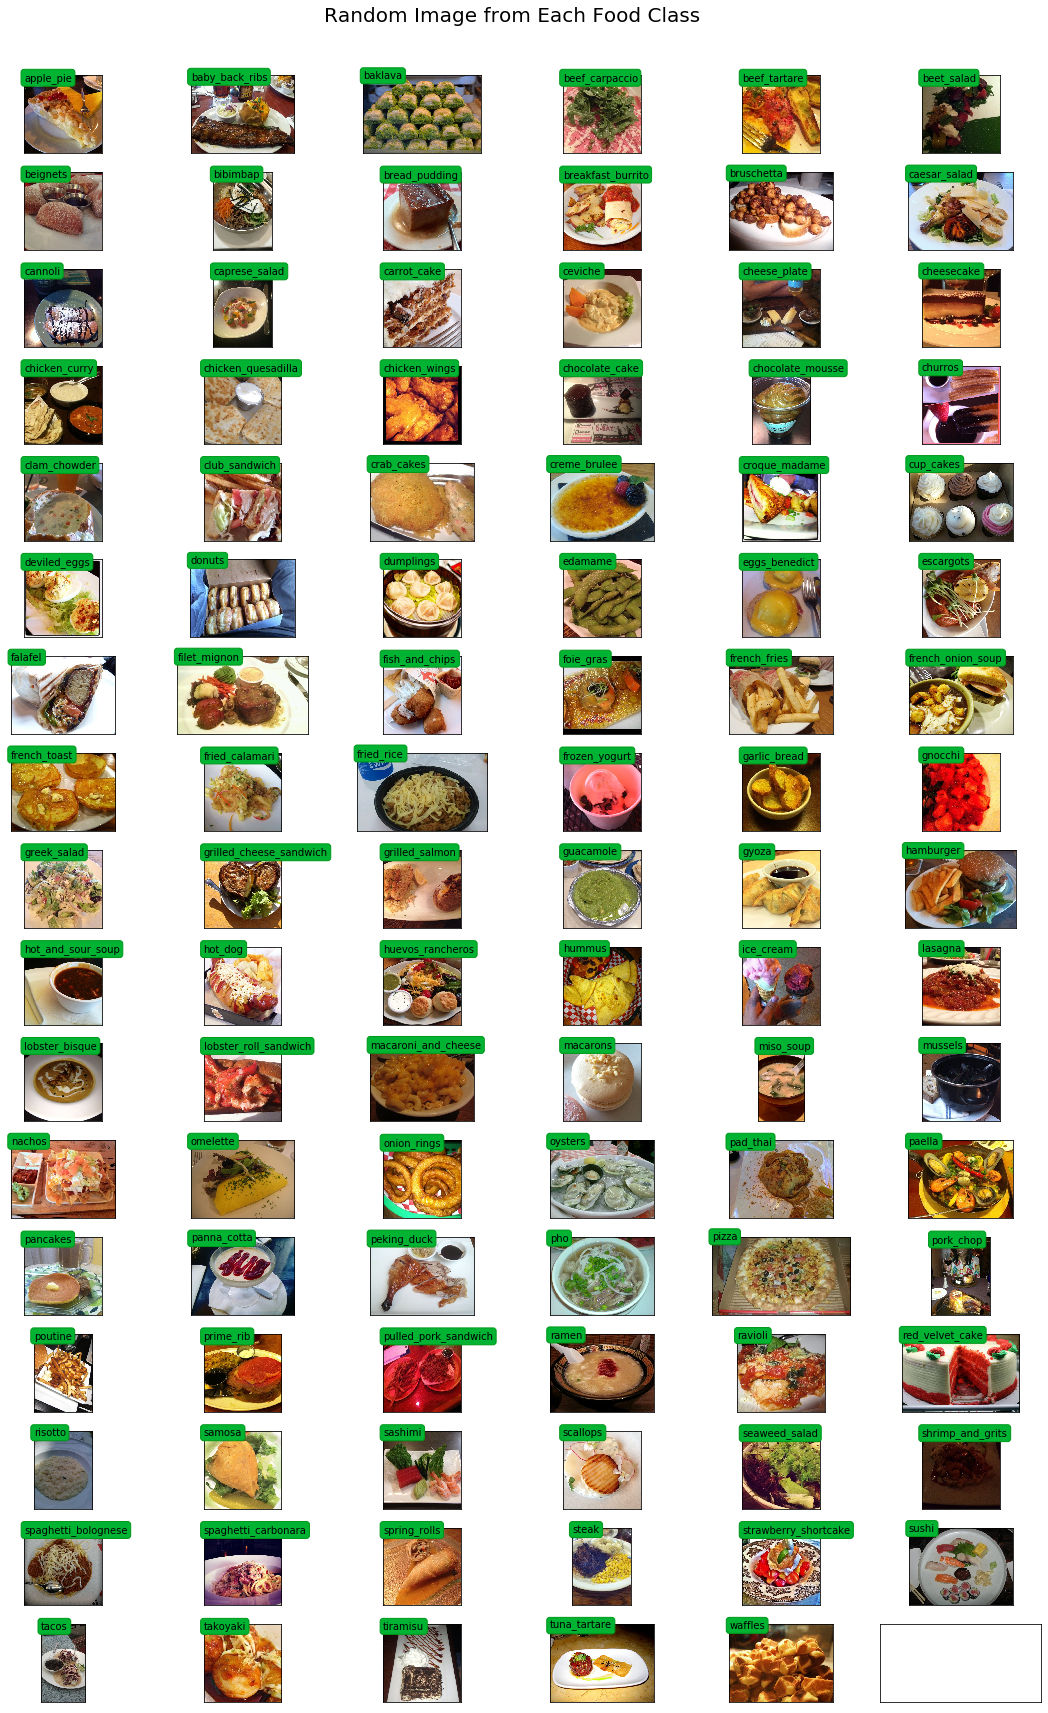

In [4]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [5]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [11]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

food-101/images
food-101/images\apple_pie
food-101/images\baby_back_ribs
food-101/images\baklava
food-101/images\beef_carpaccio
food-101/images\beef_tartare
food-101/images\beet_salad
food-101/images\beignets
food-101/images\bibimbap
food-101/images\bread_pudding
food-101/images\breakfast_burrito
food-101/images\bruschetta
food-101/images\caesar_salad
food-101/images\cannoli
food-101/images\caprese_salad
food-101/images\carrot_cake
food-101/images\ceviche
food-101/images\cheesecake
food-101/images\cheese_plate
food-101/images\chicken_curry
food-101/images\chicken_quesadilla
food-101/images\chicken_wings
food-101/images\chocolate_cake
food-101/images\chocolate_mousse
food-101/images\churros
food-101/images\clam_chowder
food-101/images\club_sandwich
food-101/images\crab_cakes
food-101/images\creme_brulee
food-101/images\croque_madame
food-101/images\cup_cakes
food-101/images\deviled_eggs
food-101/images\donuts
food-101/images\dumplings
food-101/images\edamame
food-101/images\eggs_benedic

In [11]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                #all_imgs.append(img_arr_rs)
                #all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('test', min_side=299)

0 0 apple_pie
Skipping bad image:  apple_pie 2523928.jpg
Skipping bad image:  apple_pie 2791334.jpg
Skipping bad image:  apple_pie 3635782.jpg
Skipping bad image:  apple_pie 829830.jpg
Skipping bad image:  apple_pie 861244.jpg
1 1 baby_back_ribs
Skipping bad image:  baby_back_ribs 1221409.jpg
Skipping bad image:  baby_back_ribs 18596.jpg
Skipping bad image:  baby_back_ribs 1907138.jpg
Skipping bad image:  baby_back_ribs 2042437.jpg
Skipping bad image:  baby_back_ribs 611849.jpg
2 2 baklava
Skipping bad image:  baklava 2313082.jpg
Skipping bad image:  baklava 2447796.jpg
Skipping bad image:  baklava 2662831.jpg
Skipping bad image:  baklava 3078639.jpg
Skipping bad image:  baklava 3368791.jpg
Skipping bad image:  baklava 3455436.jpg
3 3 beef_carpaccio
Skipping bad image:  beef_carpaccio 1216433.jpg
Skipping bad image:  beef_carpaccio 1636003.jpg
Skipping bad image:  beef_carpaccio 2257269.jpg
Skipping bad image:  beef_carpaccio 3009105.jpg
Skipping bad image:  beef_carpaccio 3049045.jpg


Skipping bad image:  chocolate_mousse 2375515.jpg
Skipping bad image:  chocolate_mousse 2894011.jpg
Skipping bad image:  chocolate_mousse 3710827.jpg
Skipping bad image:  chocolate_mousse 3744178.jpg
23 23 churros
Skipping bad image:  churros 1681026.jpg
Skipping bad image:  churros 2236356.jpg
Skipping bad image:  churros 2546790.jpg
Skipping bad image:  churros 3026751.jpg
Skipping bad image:  churros 3247092.jpg
Skipping bad image:  churros 3853943.jpg
Skipping bad image:  churros 841972.jpg
24 24 clam_chowder
Skipping bad image:  clam_chowder 1078583.jpg
Skipping bad image:  clam_chowder 1162869.jpg
Skipping bad image:  clam_chowder 1450190.jpg
Skipping bad image:  clam_chowder 2934681.jpg
Skipping bad image:  clam_chowder 3635647.jpg
Skipping bad image:  clam_chowder 546816.jpg
25 25 club_sandwich
Skipping bad image:  club_sandwich 1985407.jpg
Skipping bad image:  club_sandwich 2618500.jpg
Skipping bad image:  club_sandwich 599148.jpg
Skipping bad image:  club_sandwich 819992.jpg


Skipping bad image:  grilled_salmon 3383318.jpg
Skipping bad image:  grilled_salmon 3736880.jpg
Skipping bad image:  grilled_salmon 3822170.jpg
51 51 guacamole
Skipping bad image:  guacamole 1445545.jpg
Skipping bad image:  guacamole 1870881.jpg
Skipping bad image:  guacamole 3568603.jpg
Skipping bad image:  guacamole 3609337.jpg
Skipping bad image:  guacamole 787157.jpg
Skipping bad image:  guacamole 902627.jpg
Skipping bad image:  guacamole 939993.jpg
52 52 gyoza
Skipping bad image:  gyoza 1329745.jpg
Skipping bad image:  gyoza 1965682.jpg
Skipping bad image:  gyoza 2022632.jpg
Skipping bad image:  gyoza 2725545.jpg
Skipping bad image:  gyoza 3505044.jpg
Skipping bad image:  gyoza 3736279.jpg
Skipping bad image:  gyoza 3821055.jpg
Skipping bad image:  gyoza 692873.jpg
53 53 hamburger
Skipping bad image:  hamburger 1253448.jpg
Skipping bad image:  hamburger 2009324.jpg
Skipping bad image:  hamburger 2361393.jpg
Skipping bad image:  hamburger 2437718.jpg
Skipping bad image:  hamburger 

78 78 poutine
Skipping bad image:  poutine 1591648.jpg
Skipping bad image:  poutine 2102506.jpg
Skipping bad image:  poutine 2624135.jpg
Skipping bad image:  poutine 2769954.jpg
Skipping bad image:  poutine 3255943.jpg
Skipping bad image:  poutine 359382.jpg
Skipping bad image:  poutine 3679908.jpg
Skipping bad image:  poutine 3730916.jpg
Skipping bad image:  poutine 3876597.jpg
Skipping bad image:  poutine 3910643.jpg
Skipping bad image:  poutine 601600.jpg
79 79 prime_rib
Skipping bad image:  prime_rib 1549130.jpg
Skipping bad image:  prime_rib 1560483.jpg
Skipping bad image:  prime_rib 1655060.jpg
Skipping bad image:  prime_rib 1707030.jpg
Skipping bad image:  prime_rib 1732786.jpg
Skipping bad image:  prime_rib 2585835.jpg
Skipping bad image:  prime_rib 2675516.jpg
Skipping bad image:  prime_rib 2771033.jpg
Skipping bad image:  prime_rib 2925308.jpg
Skipping bad image:  prime_rib 3394968.jpg
Skipping bad image:  prime_rib 418663.jpg
Skipping bad image:  prime_rib 418668.jpg
80 80 p

In [9]:
%%time
X_train, y_train = load_images('train', min_side=299)

0 0 apple_pie
Skipping bad image:  apple_pie 1488583.jpg
Skipping bad image:  apple_pie 2163544.jpg
Skipping bad image:  apple_pie 2447106.jpg
Skipping bad image:  apple_pie 2600379.jpg
Skipping bad image:  apple_pie 2651801.jpg
Skipping bad image:  apple_pie 2819833.jpg
Skipping bad image:  apple_pie 292333.jpg
Skipping bad image:  apple_pie 3420738.jpg
Skipping bad image:  apple_pie 3748095.jpg
Skipping bad image:  apple_pie 3772671.jpg
Skipping bad image:  apple_pie 3897758.jpg
Skipping bad image:  apple_pie 3910026.jpg
Skipping bad image:  apple_pie 484038.jpg
Skipping bad image:  apple_pie 817073.jpg
1 1 baby_back_ribs
Skipping bad image:  baby_back_ribs 1128504.jpg
Skipping bad image:  baby_back_ribs 1341092.jpg
Skipping bad image:  baby_back_ribs 1499720.jpg
Skipping bad image:  baby_back_ribs 1558128.jpg
Skipping bad image:  baby_back_ribs 1576431.jpg
Skipping bad image:  baby_back_ribs 1737370.jpg
Skipping bad image:  baby_back_ribs 1772427.jpg
Skipping bad image:  baby_back_r

Skipping bad image:  bread_pudding 2498743.jpg
Skipping bad image:  bread_pudding 2574089.jpg
Skipping bad image:  bread_pudding 272991.jpg
Skipping bad image:  bread_pudding 275562.jpg
Skipping bad image:  bread_pudding 2982234.jpg
Skipping bad image:  bread_pudding 3348048.jpg
Skipping bad image:  bread_pudding 3529761.jpg
Skipping bad image:  bread_pudding 3642095.jpg
Skipping bad image:  bread_pudding 3752588.jpg
Skipping bad image:  bread_pudding 3801938.jpg
Skipping bad image:  bread_pudding 3902250.jpg
Skipping bad image:  bread_pudding 858864.jpg
9 9 breakfast_burrito
Skipping bad image:  breakfast_burrito 1061506.jpg
Skipping bad image:  breakfast_burrito 1272931.jpg
Skipping bad image:  breakfast_burrito 1356450.jpg
Skipping bad image:  breakfast_burrito 1402313.jpg
Skipping bad image:  breakfast_burrito 1599084.jpg
Skipping bad image:  breakfast_burrito 1730629.jpg
Skipping bad image:  breakfast_burrito 1841646.jpg
Skipping bad image:  breakfast_burrito 1912571.jpg
Skipping 

Skipping bad image:  cheesecake 3031568.jpg
Skipping bad image:  cheesecake 3104876.jpg
Skipping bad image:  cheesecake 3439154.jpg
Skipping bad image:  cheesecake 3643783.jpg
Skipping bad image:  cheesecake 522013.jpg
Skipping bad image:  cheesecake 641570.jpg
Skipping bad image:  cheesecake 832742.jpg
Skipping bad image:  cheesecake 935701.jpg
17 17 cheese_plate
Skipping bad image:  cheese_plate 1330725.jpg
Skipping bad image:  cheese_plate 1346370.jpg
Skipping bad image:  cheese_plate 1394032.jpg
Skipping bad image:  cheese_plate 1440307.jpg
Skipping bad image:  cheese_plate 1584094.jpg
Skipping bad image:  cheese_plate 1661866.jpg
Skipping bad image:  cheese_plate 1758358.jpg
Skipping bad image:  cheese_plate 2096642.jpg
Skipping bad image:  cheese_plate 2247228.jpg
Skipping bad image:  cheese_plate 2824074.jpg
Skipping bad image:  cheese_plate 2867064.jpg
Skipping bad image:  cheese_plate 2902263.jpg
Skipping bad image:  cheese_plate 3002497.jpg
Skipping bad image:  cheese_plate 3

Skipping bad image:  clam_chowder 3113809.jpg
Skipping bad image:  clam_chowder 3261738.jpg
Skipping bad image:  clam_chowder 3290966.jpg
Skipping bad image:  clam_chowder 3350748.jpg
Skipping bad image:  clam_chowder 3505874.jpg
Skipping bad image:  clam_chowder 3863207.jpg
Skipping bad image:  clam_chowder 3884481.jpg
Skipping bad image:  clam_chowder 3918774.jpg
Skipping bad image:  clam_chowder 804051.jpg
Skipping bad image:  clam_chowder 815481.jpg
Skipping bad image:  clam_chowder 840194.jpg
Skipping bad image:  clam_chowder 866396.jpg
25 25 club_sandwich
Skipping bad image:  club_sandwich 1202471.jpg
Skipping bad image:  club_sandwich 148714.jpg
Skipping bad image:  club_sandwich 1536205.jpg
Skipping bad image:  club_sandwich 1595649.jpg
Skipping bad image:  club_sandwich 1862986.jpg
Skipping bad image:  club_sandwich 1980684.jpg
Skipping bad image:  club_sandwich 2081422.jpg
Skipping bad image:  club_sandwich 2092938.jpg
Skipping bad image:  club_sandwich 2491436.jpg
Skipping b

Skipping bad image:  eggs_benedict 1848972.jpg
Skipping bad image:  eggs_benedict 2249036.jpg
Skipping bad image:  eggs_benedict 2256476.jpg
Skipping bad image:  eggs_benedict 2486617.jpg
Skipping bad image:  eggs_benedict 2490773.jpg
Skipping bad image:  eggs_benedict 2501606.jpg
Skipping bad image:  eggs_benedict 2644640.jpg
Skipping bad image:  eggs_benedict 2972592.jpg
Skipping bad image:  eggs_benedict 3322524.jpg
Skipping bad image:  eggs_benedict 3717570.jpg
Skipping bad image:  eggs_benedict 3782278.jpg
Skipping bad image:  eggs_benedict 659702.jpg
Skipping bad image:  eggs_benedict 768436.jpg
Skipping bad image:  eggs_benedict 867849.jpg
Skipping bad image:  eggs_benedict 874171.jpg
Skipping bad image:  eggs_benedict 939197.jpg
Skipping bad image:  eggs_benedict 98373.jpg
35 35 escargots
Skipping bad image:  escargots 1115788.jpg
Skipping bad image:  escargots 1250677.jpg
Skipping bad image:  escargots 1385312.jpg
Skipping bad image:  escargots 2728033.jpg
Skipping bad image: 

Skipping bad image:  fried_rice 2692504.jpg
Skipping bad image:  fried_rice 2984337.jpg
Skipping bad image:  fried_rice 332068.jpg
Skipping bad image:  fried_rice 3607348.jpg
Skipping bad image:  fried_rice 3618827.jpg
Skipping bad image:  fried_rice 3786263.jpg
Skipping bad image:  fried_rice 3816808.jpg
Skipping bad image:  fried_rice 3903358.jpg
Skipping bad image:  fried_rice 540673.jpg
Skipping bad image:  fried_rice 629027.jpg
Skipping bad image:  fried_rice 776408.jpg
Skipping bad image:  fried_rice 957177.jpg
45 45 frozen_yogurt
Skipping bad image:  frozen_yogurt 1164583.jpg
Skipping bad image:  frozen_yogurt 1351217.jpg
Skipping bad image:  frozen_yogurt 1530759.jpg
Skipping bad image:  frozen_yogurt 1560113.jpg
Skipping bad image:  frozen_yogurt 1560125.jpg
Skipping bad image:  frozen_yogurt 1918397.jpg
Skipping bad image:  frozen_yogurt 2178992.jpg
Skipping bad image:  frozen_yogurt 2230530.jpg
Skipping bad image:  frozen_yogurt 2293309.jpg
Skipping bad image:  frozen_yogurt

Skipping bad image:  hamburger 2207445.jpg
Skipping bad image:  hamburger 2223416.jpg
Skipping bad image:  hamburger 2361390.jpg
Skipping bad image:  hamburger 2417159.jpg
Skipping bad image:  hamburger 2466948.jpg
Skipping bad image:  hamburger 2797268.jpg
Skipping bad image:  hamburger 2879938.jpg
Skipping bad image:  hamburger 3168485.jpg
Skipping bad image:  hamburger 3309917.jpg
Skipping bad image:  hamburger 3643079.jpg
Skipping bad image:  hamburger 3647386.jpg
Skipping bad image:  hamburger 3759470.jpg
Skipping bad image:  hamburger 3821078.jpg
Skipping bad image:  hamburger 3894442.jpg
Skipping bad image:  hamburger 419342.jpg
Skipping bad image:  hamburger 474373.jpg
Skipping bad image:  hamburger 840018.jpg
54 54 hot_and_sour_soup
Skipping bad image:  hot_and_sour_soup 1268619.jpg
Skipping bad image:  hot_and_sour_soup 1655487.jpg
Skipping bad image:  hot_and_sour_soup 1827236.jpg
Skipping bad image:  hot_and_sour_soup 2092720.jpg
Skipping bad image:  hot_and_sour_soup 21935

Skipping bad image:  lobster_roll_sandwich 2244761.jpg
Skipping bad image:  lobster_roll_sandwich 2371011.jpg
Skipping bad image:  lobster_roll_sandwich 2385995.jpg
Skipping bad image:  lobster_roll_sandwich 2575053.jpg
Skipping bad image:  lobster_roll_sandwich 291287.jpg
Skipping bad image:  lobster_roll_sandwich 2940000.jpg
Skipping bad image:  lobster_roll_sandwich 3654596.jpg
Skipping bad image:  lobster_roll_sandwich 3918773.jpg
Skipping bad image:  lobster_roll_sandwich 772558.jpg
62 62 macaroni_and_cheese
Skipping bad image:  macaroni_and_cheese 1004059.jpg
Skipping bad image:  macaroni_and_cheese 1248351.jpg
Skipping bad image:  macaroni_and_cheese 1358518.jpg
Skipping bad image:  macaroni_and_cheese 1583875.jpg
Skipping bad image:  macaroni_and_cheese 1698691.jpg
Skipping bad image:  macaroni_and_cheese 1804130.jpg
Skipping bad image:  macaroni_and_cheese 1895851.jpg
Skipping bad image:  macaroni_and_cheese 1991096.jpg
Skipping bad image:  macaroni_and_cheese 2017096.jpg
Skip

Skipping bad image:  pad_thai 2575975.jpg
Skipping bad image:  pad_thai 2597567.jpg
Skipping bad image:  pad_thai 2820803.jpg
Skipping bad image:  pad_thai 2824088.jpg
Skipping bad image:  pad_thai 3029470.jpg
Skipping bad image:  pad_thai 3312134.jpg
Skipping bad image:  pad_thai 3386374.jpg
Skipping bad image:  pad_thai 3465437.jpg
Skipping bad image:  pad_thai 3537996.jpg
Skipping bad image:  pad_thai 3767446.jpg
Skipping bad image:  pad_thai 753725.jpg
Skipping bad image:  pad_thai 855443.jpg
Skipping bad image:  pad_thai 938448.jpg
71 71 paella
Skipping bad image:  paella 1678728.jpg
Skipping bad image:  paella 1696509.jpg
Skipping bad image:  paella 3263922.jpg
Skipping bad image:  paella 3432505.jpg
Skipping bad image:  paella 3550209.jpg
Skipping bad image:  paella 3786810.jpg
Skipping bad image:  paella 3831041.jpg
Skipping bad image:  paella 3838854.jpg
Skipping bad image:  paella 460308.jpg
Skipping bad image:  paella 863973.jpg
Skipping bad image:  paella 877874.jpg
72 72 p

Skipping bad image:  prime_rib 1757175.jpg
Skipping bad image:  prime_rib 1915894.jpg
Skipping bad image:  prime_rib 2018781.jpg
Skipping bad image:  prime_rib 2210666.jpg
Skipping bad image:  prime_rib 2367441.jpg
Skipping bad image:  prime_rib 2575928.jpg
Skipping bad image:  prime_rib 2684500.jpg
Skipping bad image:  prime_rib 2737859.jpg
Skipping bad image:  prime_rib 2871436.jpg
Skipping bad image:  prime_rib 2955616.jpg
Skipping bad image:  prime_rib 306878.jpg
Skipping bad image:  prime_rib 322287.jpg
Skipping bad image:  prime_rib 3229287.jpg
Skipping bad image:  prime_rib 3286982.jpg
Skipping bad image:  prime_rib 3385821.jpg
Skipping bad image:  prime_rib 3595631.jpg
Skipping bad image:  prime_rib 3811924.jpg
Skipping bad image:  prime_rib 3819263.jpg
Skipping bad image:  prime_rib 811245.jpg
Skipping bad image:  prime_rib 821163.jpg
80 80 pulled_pork_sandwich
Skipping bad image:  pulled_pork_sandwich 1004064.jpg
Skipping bad image:  pulled_pork_sandwich 1210600.jpg
Skipping 

Skipping bad image:  seaweed_salad 614972.jpg
Skipping bad image:  seaweed_salad 714760.jpg
Skipping bad image:  seaweed_salad 827864.jpg
Skipping bad image:  seaweed_salad 888976.jpg
Skipping bad image:  seaweed_salad 952043.jpg
89 89 shrimp_and_grits
Skipping bad image:  shrimp_and_grits 1030610.jpg
Skipping bad image:  shrimp_and_grits 1052125.jpg
Skipping bad image:  shrimp_and_grits 1137707.jpg
Skipping bad image:  shrimp_and_grits 1203288.jpg
Skipping bad image:  shrimp_and_grits 1295413.jpg
Skipping bad image:  shrimp_and_grits 1554671.jpg
Skipping bad image:  shrimp_and_grits 1837808.jpg
Skipping bad image:  shrimp_and_grits 2105194.jpg
Skipping bad image:  shrimp_and_grits 2133410.jpg
Skipping bad image:  shrimp_and_grits 2368211.jpg
Skipping bad image:  shrimp_and_grits 2401930.jpg
Skipping bad image:  shrimp_and_grits 2604578.jpg
Skipping bad image:  shrimp_and_grits 2762992.jpg
Skipping bad image:  shrimp_and_grits 2859243.jpg
Skipping bad image:  shrimp_and_grits 2916027.j

Skipping bad image:  tacos 3249128.jpg
Skipping bad image:  tacos 3564496.jpg
Skipping bad image:  tacos 3590883.jpg
Skipping bad image:  tacos 3704862.jpg
Skipping bad image:  tacos 3792612.jpg
Skipping bad image:  tacos 3890040.jpg
Skipping bad image:  tacos 712764.jpg
Skipping bad image:  tacos 749374.jpg
Skipping bad image:  tacos 846311.jpg
Skipping bad image:  tacos 952885.jpg
Skipping bad image:  tacos 975798.jpg
97 97 takoyaki
Skipping bad image:  takoyaki 1116166.jpg
Skipping bad image:  takoyaki 1208551.jpg
Skipping bad image:  takoyaki 1470509.jpg
Skipping bad image:  takoyaki 1630260.jpg
Skipping bad image:  takoyaki 1692042.jpg
Skipping bad image:  takoyaki 2098990.jpg
Skipping bad image:  takoyaki 2128809.jpg
Skipping bad image:  takoyaki 2284798.jpg
Skipping bad image:  takoyaki 2555608.jpg
Skipping bad image:  takoyaki 2555811.jpg
Skipping bad image:  takoyaki 2659561.jpg
Skipping bad image:  takoyaki 2817155.jpg
Skipping bad image:  takoyaki 2861548.jpg
Skipping bad im

In [22]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16
INPUT_SIZE = (299, 299)
EPOCH = 32
n_classes = 101
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                    samplewise_std_normalization=False,  # divide each input by its std
                                   zoom_range=[.8, 1],
                                   rotation_range=45,
#                                    zca_whitening=True,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   channel_shift_range=30,
                                   fill_mode='reflect'
                                  )

#train_datagen.config['random_crop_size'] = (299, 299)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                   seed=11
                                                   )

val_generator = train_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                               seed=11
                                                   )


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Wall time: 3.03 s


In [23]:
%%time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
K.clear_session()

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

D:\lxd\anaconda\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(101, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
D:\lxd\anaconda\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [27]:
#history = model.fit_generator(train_generator,
      #              validation_data=val_generator,
       #             nb_val_samples=val_generator.samples // BATCH_SIZE,
      #              samples_per_epoch= train_generator.samples // BATCH_SIZE,
        #           nb_epoch=32,
         ##           verbose=2,
        #            callbacks=[lr_scheduler, csv_logger, checkpointer])
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
                              validation_data = val_generator,
                              validation_steps = val_generator.samples // BATCH_SIZE,
                              epochs=32,
                              verbose=1,
                              callbacks=[lr_scheduler, csv_logger, checkpointer])

Epoch 1/32
4734/4734 [==============================] - 1906s 403ms/step - loss: 2.4655 - accuracy: 0.4278 - val_loss: 1.7557 - val_accuracy: 0.5285

Epoch 00001: val_loss improved from inf to 1.75569, saving model to model4.01-1.76.hdf5
Epoch 2/32
4734/4734 [==============================] - 1891s 399ms/step - loss: 1.9180 - accuracy: 0.5565 - val_loss: 1.4245 - val_accuracy: 0.6013

Epoch 00002: val_loss improved from 1.75569 to 1.42452, saving model to model4.02-1.42.hdf5
Epoch 3/32
4734/4734 [==============================] - 1883s 398ms/step - loss: 1.6845 - accuracy: 0.6107 - val_loss: 1.6850 - val_accuracy: 0.6317

Epoch 00003: val_loss did not improve from 1.42452
Epoch 4/32
4734/4734 [==============================] - 1895s 400ms/step - loss: 1.5323 - accuracy: 0.6484 - val_loss: 1.1133 - val_accuracy: 0.6737

Epoch 00004: val_loss improved from 1.42452 to 1.11330, saving model to model4.04-1.11.hdf5
Epoch 5/32
4734/4734 [==============================] - 1897s 401ms/step - lo

In [28]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

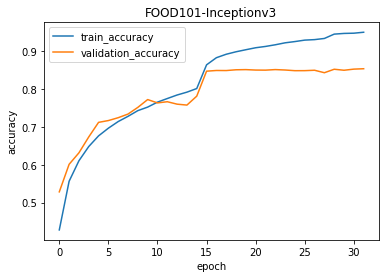

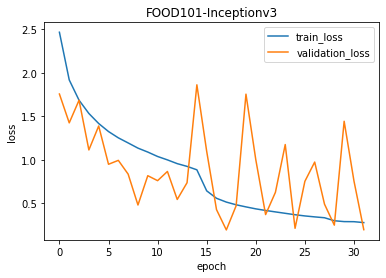

In [29]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')